In [1]:
from tqdm.notebook import tqdm
from glob import glob

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

## UW-Madison GI Tract Image Segmentation

## 1. Introduction

This competition's objective is segmentation of stomach and intestines on MRI scans. The MRI scans are from actual cancer patients who had 1-5 MRI scans on separate days during their radiation treatment. There are total of 85 cases, 274 MRI scans and 33913 annotations in training set, and there are roughly 50 cases in hidden test set.

There are 3 columns in `train.csv` file named id, class and segmentation.

* `id` - Unique ID of the slice
* `class` - Class of the object (large bowel, small bowel or stomach)
* `segmentation` - Run length encoded segmentation masks

id column can be decomposed into 3 columns; case, day and slice. Those columns can be used for selecting slices from directories.

* `case` - Case ID
* `day` - Scan day
* `slice` - Slice number

In [2]:
df_train = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/train.csv')
print(f'Training Set Shape: {df_train.shape} - {df_train[~df_train["segmentation"].isnull()].shape[0]} Annotations - Memory Usage: {df_train.memory_usage().sum() / 1024 ** 2:.2f} MB')

df_train = pd.concat((
    df_train,
    df_train['id'].str.split('_', expand=True).drop(columns=[2]).rename(columns={0: 'case', 1: 'day', 3: 'slice_number'})
), axis=1)

Training Set Shape: (115488, 3) - 33913 Annotations - Memory Usage: 2.64 MB


Training annotations are provided as run-length encoded binary segmentation masks. They have to be decoded into 2 dimensional arrays in order to be processed which can be done with the function defined below.

In [3]:
def decode_rle_mask(rle_mask, shape):

    """
    Decode run-length encoded segmentation mask string into 2d array

    Parameters
    ----------
    rle_mask (str): Run-length encoded segmentation mask string
    shape (tuple): Height and width of the mask

    Returns
    -------
    mask [numpy.ndarray of shape (height, width)]: Decoded 2d segmentation mask
    """

    rle_mask = rle_mask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (rle_mask[0:][::2], rle_mask[1:][::2])]
    starts -= 1
    ends = starts + lengths

    mask = np.zeros((shape[0] * shape[1]), dtype=np.uint8)
    for start, end in zip(starts, ends):
        mask[start:end] = 1

    mask = mask.reshape(shape[0], shape[1])
    return mask


## 2. Metadata

MRIs are in 16-bit grayscale PNG format, not in DICOM format so their metadata is not available. However, filenames of slices include image height, width and pixel spacings on x and y axes. That information can be extracted from them.

* `image_height` - Image height in pixels
* `image_width` - Image width in pixels
* `image_vertical_pixel_spacing` - Physical distance in real world that corresponds to vertical distance between two pixel centers
* `image_horizontal_pixel_spacing` - Physical distance in real world that corresponds to horizontal distance between two pixel centers

Image statistics such as mean, std, min and max can be extracted for normalization and further analysis.

* `image_mean` - Image mean pixel value
* `image_std` - Image standard deviation of pixel values 
* `image_min` - Image minimum pixel value
* `image_max` - Image maximum pixel value

Finally, additional statistics such as area of objects can be extracted from annotations.

* `mask_area` - Total area in binary segmentation mask

In [4]:
slice_filenames = glob('../input/uw-madison-gi-tract-image-segmentation/train/*/*/scans/*.png')

for filename in tqdm(slice_filenames):
    
    case, day = filename.split('/')[5].split('_')
    filename_split = filename.split('/')[-1].split('_')
    slice_number = filename_split[1]
    image_height = int(filename_split[2])
    image_width = int(filename_split[3])
    image_vertical_pixel_spacing = float(filename_split[4])
    image_horizontal_pixel_spacing = float(filename_split[5].replace('.png', ''))
    
    # Extract metadata from filename
    slice_idx = (df_train['case'] == case) & (df_train['day'] == day) & (df_train['slice_number'] == slice_number)
    df_train.loc[slice_idx, 'image_height'] = image_height
    df_train.loc[slice_idx, 'image_width'] = image_width
    df_train.loc[slice_idx, 'image_vertical_pixel_spacing'] = image_vertical_pixel_spacing
    df_train.loc[slice_idx, 'image_horizontal_pixel_spacing'] = image_horizontal_pixel_spacing
    
    # Extract metadata from image
    image = cv2.imread(filename, -1)
    df_train.loc[slice_idx, 'image_mean'] = np.mean(image)
    df_train.loc[slice_idx, 'image_std'] = np.std(image)
    df_train.loc[slice_idx, 'image_min'] = np.min(image)
    df_train.loc[slice_idx, 'image_max'] = np.max(image)
    
    # Extract metadata from annotation
    for row_idx, row in df_train.loc[slice_idx].iterrows():
        if isinstance(row['segmentation'], str):
            mask = decode_rle_mask(row['segmentation'], (image_height, image_width))
            df_train.loc[row_idx, 'mask_area'] = np.sum(mask)


df_train['slice_count'] = df_train.groupby(['case', 'day'])['slice_number'].transform('count') / 3
df_train['slice_count'] = df_train['slice_count'].astype(np.uint16)
df_train['image_height'] = df_train['image_height'].astype(np.uint16)
df_train['image_width'] = df_train['image_width'].astype(np.uint16)
df_train['image_vertical_pixel_spacing'] = df_train['image_vertical_pixel_spacing'].astype(np.float32)
df_train['image_horizontal_pixel_spacing'] = df_train['image_horizontal_pixel_spacing'].astype(np.float32)
df_train['image_mean'] = df_train['image_mean'].astype(np.float32)
df_train['image_std'] = df_train['image_std'].astype(np.float32)
df_train['image_min'] = df_train['image_min'].astype(np.float32)
df_train['image_max'] = df_train['image_max'].astype(np.float32)

  0%|          | 0/38496 [00:00<?, ?it/s]

There are 4 different image dimensions in training set and they are 266x266, 360x310, 276x276 and 234x234. Last two of them are very rare and most of the images are either 266x266 or 360x310. However, raw image dimensions are meaningless since there are borders around them. After removing borders, their dimensions would became smaller. Slice count is 144 in the most of the cases but some of the scans have 80 slices.

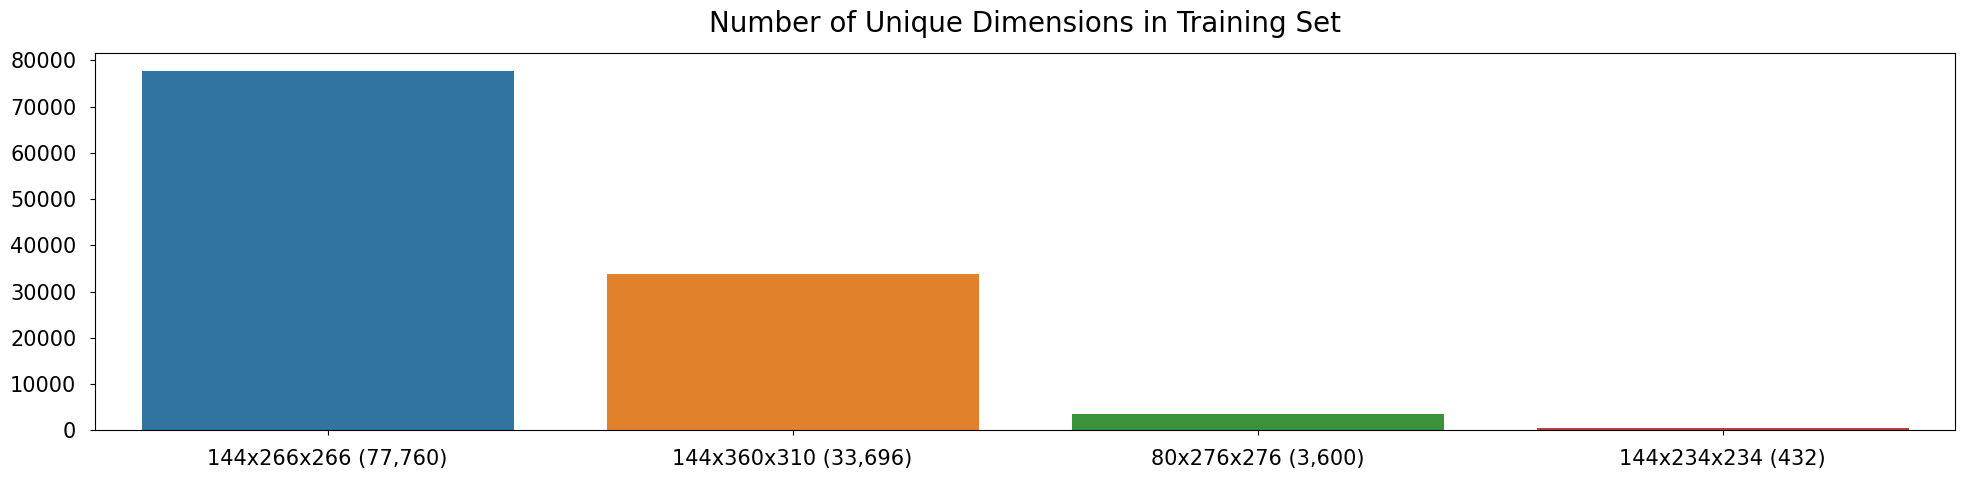

In [5]:
df_train['image_dimensions'] = df_train['slice_count'].astype(str) + 'x' + df_train['image_height'].astype(str) + 'x' + df_train['image_width'].astype(str)

def visualize_image_dimensions_distribution(df):
    
    fig, ax = plt.subplots(figsize=(24, 5), dpi=100)

    sns.barplot(
        x=df['image_dimensions'].value_counts().index,
        y=df['image_dimensions'].value_counts().values,
        ax=ax
    )

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([f'{x} ({value_count:,})' for value_count, x in zip(df['image_dimensions'].value_counts().values, df['image_dimensions'].value_counts().index)])
    ax.tick_params(axis='x', labelsize=15, pad=10)
    ax.tick_params(axis='y', labelsize=15, pad=10)
    ax.set_title('Number of Unique Dimensions in Training Set', size=20, pad=15)

    plt.show()

    
visualize_image_dimensions_distribution(df_train)

Most of the images have 1.5 mm pixel spacings in both vertical and horizontal axes. There are only 3600 images that have 1.63 mm pixel spacings and those images are the same ones with 276x276 image dimensions. Even though metadata is not provided, evidences suggest that MRI scans in training set are most likely taken from the same machine with similar configurations. Scans with 80x276x276 dimensions could be exception.

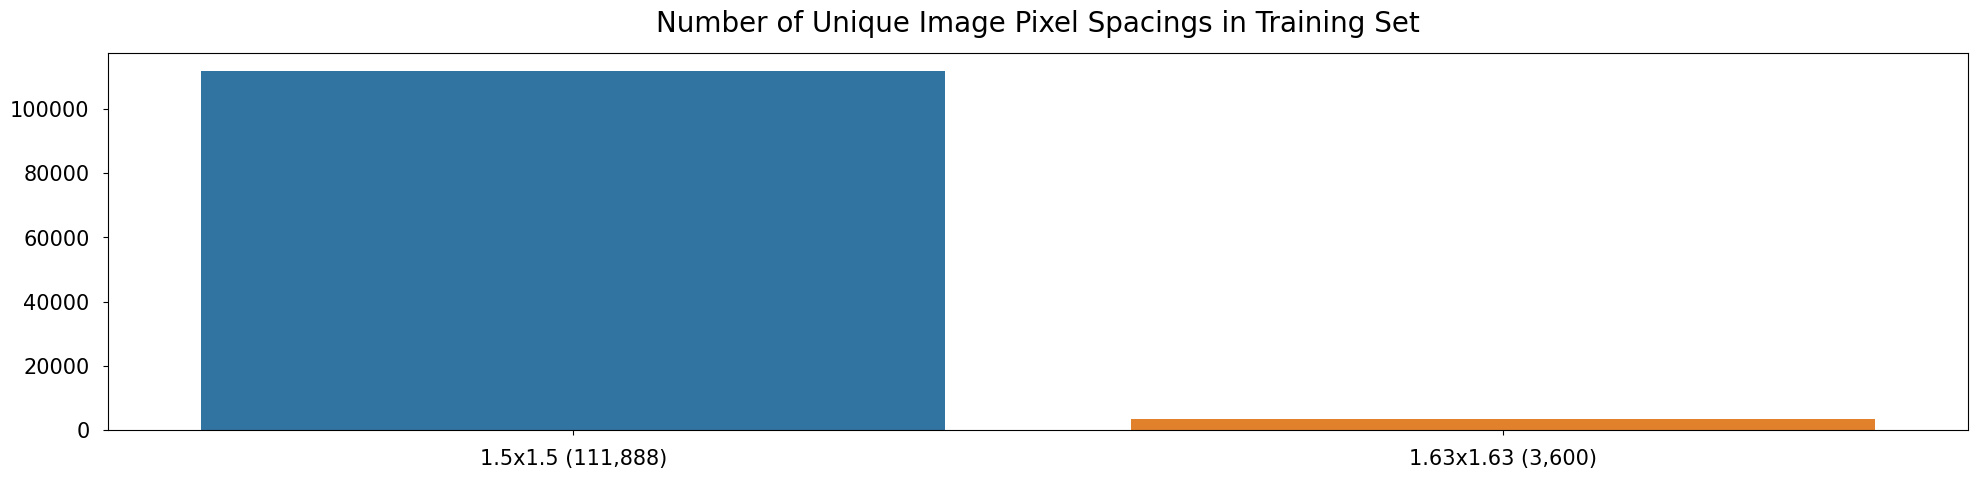

In [6]:
df_train['image_pixel_spacings'] = df_train['image_vertical_pixel_spacing'].astype(str) + 'x' + df_train['image_horizontal_pixel_spacing'].astype(str)

def visualize_image_pixel_spacings_distribution(df):
    
    fig, ax = plt.subplots(figsize=(24, 5), dpi=100)

    sns.barplot(
        x=df['image_pixel_spacings'].value_counts().index,
        y=df['image_pixel_spacings'].value_counts().values,
        ax=ax
    )

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([f'{x} ({value_count:,})' for value_count, x in zip(df['image_pixel_spacings'].value_counts().values, df['image_pixel_spacings'].value_counts().index)])
    ax.tick_params(axis='x', labelsize=15, pad=10)
    ax.tick_params(axis='y', labelsize=15, pad=10)
    ax.set_title('Number of Unique Image Pixel Spacings in Training Set', size=20, pad=15)

    plt.show()


visualize_image_pixel_spacings_distribution(df_train)

## 3. Objects

There are 3 classes of objects in annotations. They are large bowel, small bowel and stomach. Their number of annotations are in this order as from most to least annotated class. Differences in their number of annotations show that large bowel takes more space on z-axis while others take less.

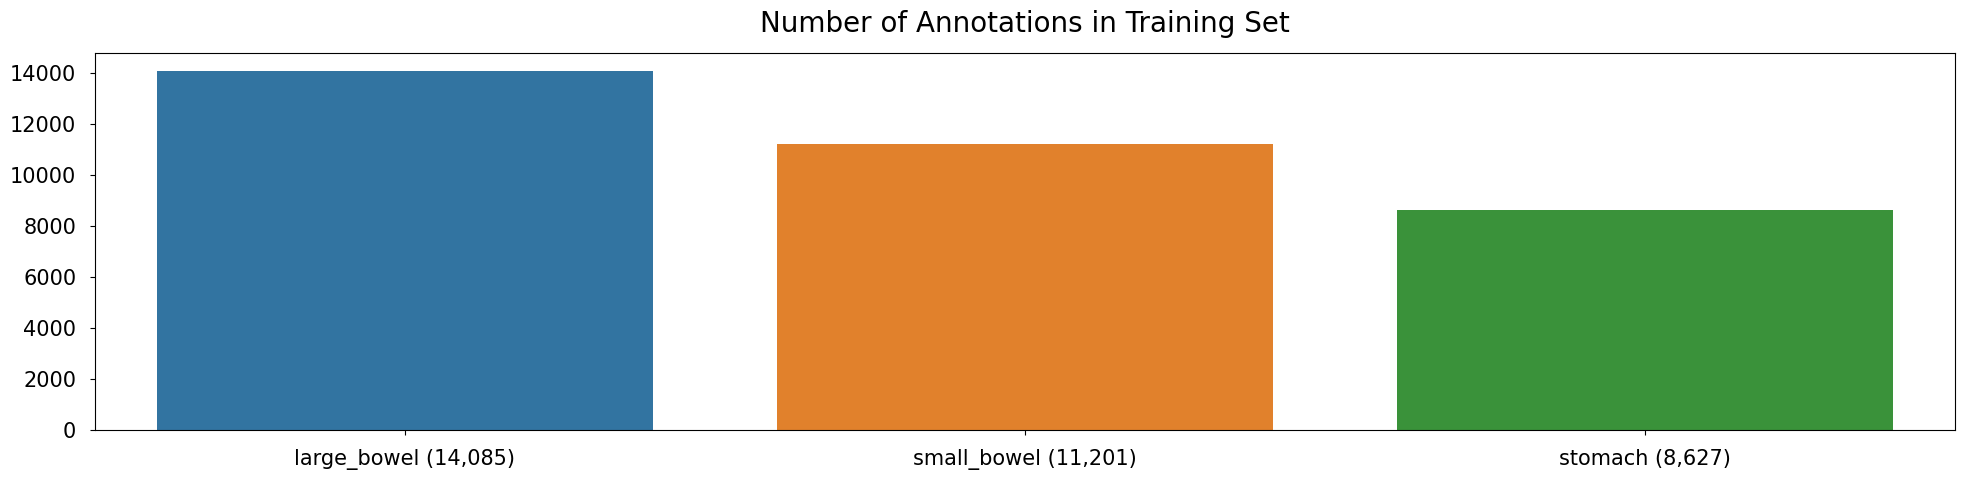

In [7]:
def visualize_annotation_distribution(df):
    
    fig, ax = plt.subplots(figsize=(24, 5), dpi=100)

    sns.barplot(
        x=df.loc[~df['segmentation'].isnull(), 'class'].value_counts().index,
        y=df.loc[~df['segmentation'].isnull(), 'class'].value_counts().values,
        ax=ax
    )

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([f'{x} ({value_count:,})' for value_count, x in zip(df.loc[~df['segmentation'].isnull(), 'class'].value_counts().values, df.loc[~df['segmentation'].isnull(), 'class'].value_counts().index)])
    ax.tick_params(axis='x', labelsize=15, pad=10)
    ax.tick_params(axis='y', labelsize=15, pad=10)
    ax.set_title('Number of Annotations in Training Set', size=20, pad=15)

    plt.show()

    
visualize_annotation_distribution(df_train)

Mask area distributions among classes are quite different. Small bowel areas are larger than large bowel areas which suggests that small bowel takes more space in x and y axes while large bowel takes more space in z-axis. Stomach is the smallest class which can be seen from its mask area distribution and number of annotations.

mask_area
---------
Class large_bowel Mean: 1557.2295  -  Median: 1312.0000  -  Std: 1104.3189 - Min: 11.0000 -  Max: 6964.0000
Class small_bowel Mean: 1792.7473  -  Median: 1600.0000  -  Std: 1168.3695 - Min: 29.0000 -  Max: 8025.0000
Class stomach Mean: 1289.1906  -  Median: 962.0000  -  Std: 1031.8699 - Min: 12.0000 -  Max: 6917.0000


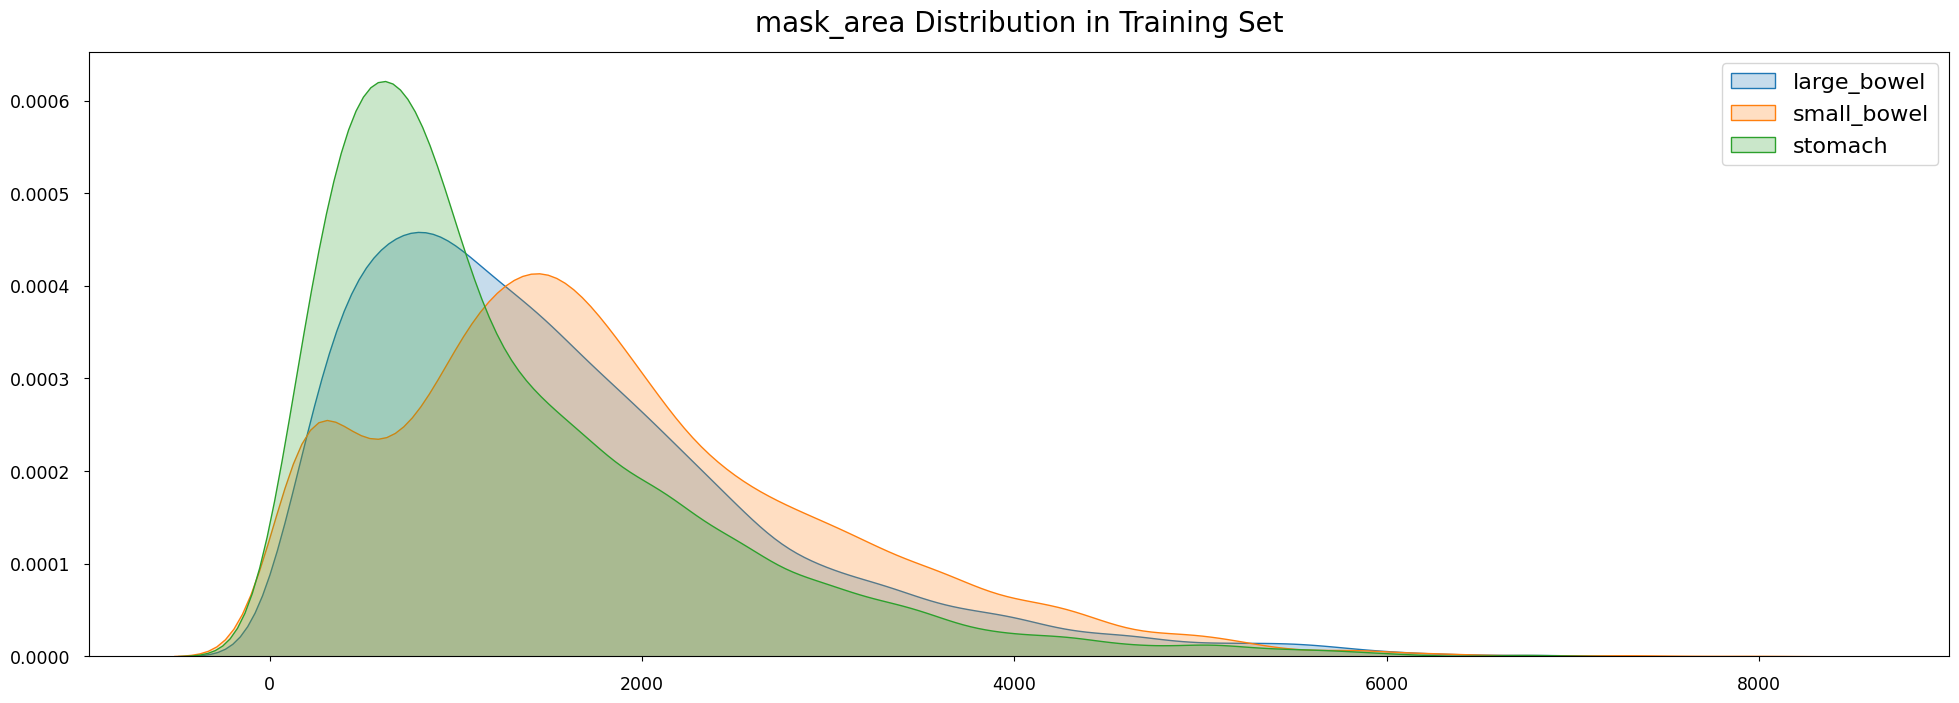

In [8]:
def visualize_feature_distribution_for_classes(df, feature):
    
    print(f'{feature}\n{"-" * len(feature)}')
    print(f'Class large_bowel Mean: {df.loc[df["class"] == "large_bowel"][feature].mean():.4f}  -  Median: {df.loc[df["class"] == "large_bowel"][feature].median():.4f}  -  Std: {df.loc[df["class"] == "large_bowel"][feature].std():.4f} - Min: {df.loc[df["class"] == "large_bowel"][feature].min():.4f} -  Max: {df.loc[df["class"] == "large_bowel"][feature].max():.4f}')
    print(f'Class small_bowel Mean: {df.loc[df["class"] == "small_bowel"][feature].mean():.4f}  -  Median: {df.loc[df["class"] == "small_bowel"][feature].median():.4f}  -  Std: {df.loc[df["class"] == "small_bowel"][feature].std():.4f} - Min: {df.loc[df["class"] == "small_bowel"][feature].min():.4f} -  Max: {df.loc[df["class"] == "small_bowel"][feature].max():.4f}')
    print(f'Class stomach Mean: {df.loc[df["class"] == "stomach"][feature].mean():.4f}  -  Median: {df.loc[df["class"] == "stomach"][feature].median():.4f}  -  Std: {df.loc[df["class"] == "stomach"][feature].std():.4f} - Min: {df.loc[df["class"] == "stomach"][feature].min():.4f} -  Max: {df.loc[df["class"] == "stomach"][feature].max():.4f}')

    fig, ax = plt.subplots(figsize=(24, 8), dpi=100)
    sns.kdeplot(df.loc[df['class'] == 'large_bowel'][feature], label='large_bowel', fill=True)
    sns.kdeplot(df.loc[df['class'] == 'small_bowel'][feature], label='small_bowel', fill=True)
    sns.kdeplot(df.loc[df['class'] == 'stomach'][feature], label='stomach', fill=True)
    
    ax.legend(prop={'size': 16})
    ax.tick_params(axis='x', labelsize=12.5, pad=10)
    ax.tick_params(axis='y', labelsize=12.5, pad=10)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(f'{feature} Distribution in Training Set', fontsize=20, pad=15)
    
    plt.show()
    

features = ['mask_area']
for feature in features:
    visualize_feature_distribution_for_classes(df=df_train, feature=feature)


## 4. MRI Scans

In [9]:
# To Be Continued